---

<center>
<h1>Pronóstico de la productividad forrajera y balance</h1>
<h1>hídrico en la región de los pastizales del Río de la Plata</h1>
</center>

---


<br>
<br>
<ul>
    <li>Bartol, Tomás Augusto</li>
    <li>Peiretti, Pablo </li>
    <li>Sánchez, Milagros Verónica </li>
</li>
</ul>


<br>
<h2>Abstract</h2>

This notebook was created with the purpose of introducing the use of multispectral satellite images as a tool for predicting forage production and water balance in the grasslands of the Río de la Plata. Based on this, the aim is to achieve a more efficient and precise management of resources. Additionally, there will be an attempt to increase livestock productivity by reducing variability in forage production. 

---

# Modules 

This section contains the import statements for external Python modules that are used throughout the notebook. This section is where external libraries or packages are loaded in order to provide additional functionality beyond the basic Python capabilities


In [1]:
### Load the modules ### 
import sys
import tensorflow as tf
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ipywidgets as widgets
from folium import plugins
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint, MultiPolygon
from sklearn.cluster import KMeans
import folium
from branca.colormap import linear
import geopandas as gpd
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Input, Dense, LSTM
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
from branca.colormap import linear
from IPython.display import display
from folium import plugins
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
import ipywidgets as widgets
from IPython.display import display

### Load In-House modules ###  
sys.path.append('../src/')
import data
import reporting
import models


--- 

# Macros 

The Globals and Macros section in this codebase serves as a centralized hub for managing global variables and macros that impact the entire project. This section is dedicated to storing constants, configuration parameters, and reusable macros that streamline the development process and ensure consistency across various components.

In [2]:
#DATABASE_PATH = "Database\database.csv"
SAMPLES_PER_LOCATION = 460
COLORS = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', \
     'lightred', 'darkblue', 'darkgreen', 'cadetblue', \
     'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', \
     'black', 'lightgray', 'red', 'blue', 'green', 'purple', \
     'orange', 'darkred', 'lightred', 'beige', 'darkblue', \
     'darkgreen', 'cadetblue', 'darkpurple','pink', 'lightblue', \
     'lightgreen', 'gray', 'black', 'lightgray', 'beige' ]
CLUSTERS_QTY = 16

PPNA_FILE = 'PPNA_denso_16d_fechas_ordenadas.csv'
TEMP_FILE = 'TEMP_denso_16d_fechas_ordenadas.csv'
PPT_FILE  = 'PPT_denso_16d_fechas_ordenadas.csv'
DATE_FILE = 'fechas modis ANII.csv'
CORD_FILE = 'xy_denso.csv'

---

# Data

In this dedicated segment, our primary emphasis will be on the comprehensive visualization and skillful manipulation of the data provided by the MODIS remote sensor. We will delve into the intricacies of presenting the information in a visually impactful manner, ensuring that we not only harness the power of visualization techniques but also adeptly navigate the nuances of manipulating the MODIS dataset for meaningful insights.

In [3]:
ppna_df = data.ppna_database_ingest(PPNA_FILE)
temp_df = data.temp_database_ingest(TEMP_FILE)
ppt_df = data.ppt_database_ingest(PPT_FILE)
date_df = data.date_database_ingest(DATE_FILE)
cord_df = data.cord_database_ingest (CORD_FILE)
ppna_df_feature_cross = data.DataManager(data.merge_databases(ppna_df,temp_df,ppt_df,cord_df,date_df))
ppna_df_feature_cross.info()

<class 'data.data_manager.DataManager'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   ppna       690000 non-null  float64       
 1   temp       690000 non-null  float64       
 2   ppt        690000 non-null  float64       
 3   date       690000 non-null  datetime64[ns]
 4   latitude   690000 non-null  float64       
 5   longitude  690000 non-null  float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 31.6 MB



## Data Visualization 


## Data Clustering
We employ the KMeans algorithm to cluster latitude and longitude data into geographic clusters, allowing us to identify spatial patterns and segment similar areas. This technique enriches our data with contextual information about geographical location, potentially enhancing the predictive capability of our neural network by capturing more complex spatial relationships and patterns otherwise representing Lat and Long as floating-points would provide almost no predictive power
Kmeans uses vector quantization and aims to assign each observation to the cluster with the nearest mean or centroid, which serves as a prototype for the cluster. The goal is to minimize the sum of squared distances between the data points and their corresponding cluster centroids, resulting in clusters that are internally homogeneous and distinct from each other.




### Tests for efficient data clustering

Elbow method is used to determine the most efficient number of centroids. The optimal value will be that 
in which the function plot "bends" and "forms an elbow"

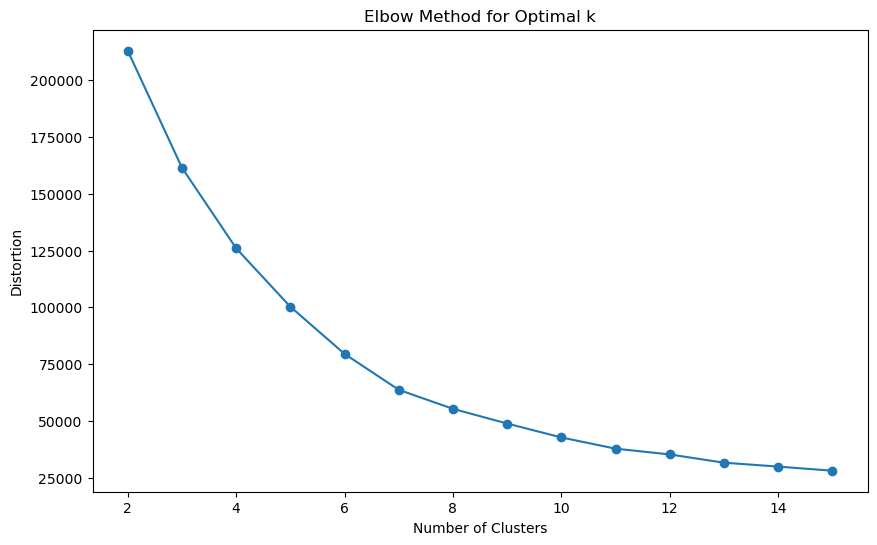

In [6]:
def elbow_method(data, max_clusters=10):
    X = data[['latitude', 'longitude']]

    distortions = []
    for i in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)


    plt.figure(figsize=(10, 6))
    plt.plot(range(2, max_clusters + 1), distortions, marker='o')
    plt.title('Elbow Method for Optimal k')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Distortion')
    plt.show()


elbow_method(ppna_df_feature_cross, 15)

Average Silhouette method is another tool to determine the most efficient number of centroids. The optimal value will be that for which the 
silhouette score is closer to 1, indicating that every datapoint is near the centroid and the clusters are more compact.
The method is not 100% efficient as the dataset must be shortened to one sample per location because of computing limitations


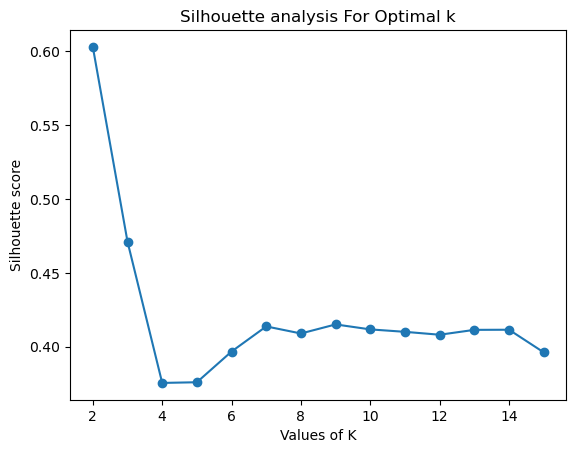

In [7]:
def silhouette_method(dataset, max_clusters):
 
    k_values = range(2, max_clusters + 1)
    silhouette_scores = []

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init = 10)
        cluster_labels = kmeans.fit_predict(dataset)
        silhouette_avg = silhouette_score(dataset, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    plt.plot(k_values, silhouette_scores, marker='o')
    plt.xlabel('Values of K') 
    plt.ylabel('Silhouette score') 
    plt.title('Silhouette analysis For Optimal k')
    plt.show()

   
    optimal_k = k_values[np.argmax(silhouette_scores)]
    return optimal_k

counter = 0
X = []
for _, row in ppna_df_feature_cross.iterrows():

    if counter % SAMPLES_PER_LOCATION == 0:
        X.append([row["latitude"], row["longitude"]])
    
    counter += 1
    
optimal_k = silhouette_method(X, 15)

Calinski-Harabasz method to determine the most efficient number of centroids. The optimal value will be that for which the 
index is higher, indicating that the clusters are more separated and defined.

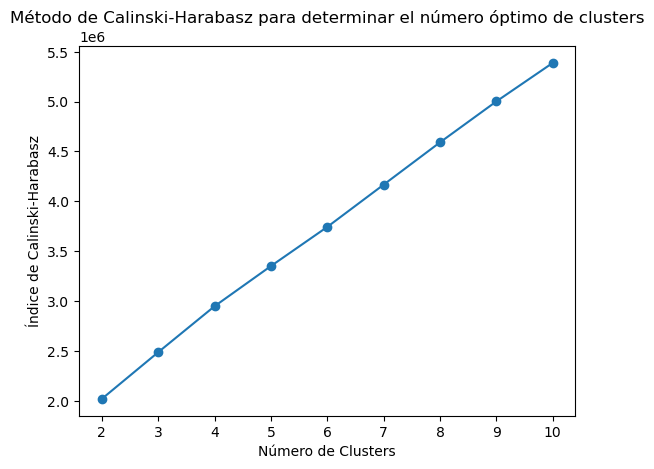

In [8]:
def calinski_harabasz_method(X, max_clusters):
    scores = []
    
    for k in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(X)
        score = calinski_harabasz_score(X, kmeans.labels_)
        scores.append(score)
    
    plt.plot(range(2, max_clusters + 1), scores, marker='o')
    plt.xlabel('Número de Clusters')
    plt.ylabel('Índice de Calinski-Harabasz')
    plt.title('Método de Calinski-Harabasz para determinar el número óptimo de clusters')
    plt.show()


X = ppna_df_feature_cross[['latitude', 'longitude', 'ppna']]
calinski_harabasz_method(X, 10)

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans(n_init=10)
X = ppna_df_feature_cross[['latitude', 'longitude', 'ppna']]
# k is range of number of clusters.
visualizer = KElbowVisualizer(model, k=(2,30),metric='calinski_harabasz', timings= True)
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()

### Clustering Division

In [4]:

X = ppna_df_feature_cross[['latitude', 'longitude']]
kmeans = KMeans(
    init="random",
    n_clusters=CLUSTERS_QTY,
    n_init=10,
    max_iter=300,
    random_state=42
).fit(X)

labels = kmeans.labels_
X['cluster'] = labels


C:\Users\CARLOS\AppData\Local\Temp\ipykernel_9684\3129208140.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster'] = labels


In [6]:
centers = kmeans.cluster_centers_
print(centers)

[[-30.48298611 -57.3616541 ]
 [-31.29632936 -57.16290396]
 [-32.3488871  -56.0573979 ]
 [-30.84571759 -57.13467367]
 [-31.62042059 -56.91572428]
 [-32.03378843 -56.42565959]
 [-30.39128925 -56.83621575]
 [-32.45977953 -56.97658578]
 [-30.74364149 -57.59685811]
 [-32.49149709 -56.4161372 ]
 [-33.01992305 -56.76179882]
 [-31.15738782 -57.54431161]
 [-31.02104952 -56.18669402]
 [-32.99836538 -56.12061398]
 [-31.56528799 -57.510104  ]
 [-30.971875   -56.68880527]]


### Map of Clustering Classification separated by color

In [9]:
map = folium.Map(location=[ppna_df_feature_cross['latitude'].mean(), ppna_df_feature_cross['longitude'].mean()], zoom_start=6)
counter = 0
for _, row in X.iterrows():

    if counter % SAMPLES_PER_LOCATION == 0:
        folium.CircleMarker(
            location=[row["latitude"], row["longitude"]],
            radius=6, 
            weight=2, 
            fill=True, 
            fill_color=COLORS[int(row["cluster"])],
            color=COLORS[int(row["cluster"])]
        ).add_to(map)
    

    counter += 1
map


In [19]:
'''
Plot every centroid on the map, color coded by the cluster they belong to
'''

map = folium.Map(location=[ppna_df_feature_cross['latitude'].mean(), ppna_df_feature_cross['longitude'].mean()], zoom_start=6)

counter = 0
for centroid in centers:

    folium.CircleMarker(
        location=[centroid[0], centroid[1]],
        radius=6, 
        weight=2, 
        fill=True, 
        fill_color=COLORS[counter],
        color=COLORS[counter]
        ).add_to(map)

    counter += 1

map

In [23]:
'''
Prints map with cluster contours obtained from the dataset locations. It uses a convex_hull (hull= shell, contour)
which sets the simplest contour to be drawn around a given set of points (like a rubber band on tacks)
'''


#Create a dictionary with points grouped by clusters. The cluster id is the dictionary key and the coordinates are the dictionary data
clustered_points = {}
for _, row in X.iterrows():
    cluster_id = int(row["cluster"])
    if cluster_id not in clustered_points:
        clustered_points[cluster_id] = []
    clustered_points[cluster_id].append((row["latitude"], row["longitude"]))

# Create a polygon dictionary. Key=cluster id; data=convex hull.
cluster_polygons = {}
for cluster_id, points in clustered_points.items():
    multipoint = MultiPoint(points)
    convex_hull = multipoint.convex_hull
    cluster_polygons[cluster_id] = convex_hull

map = folium.Map(location=[ppna_df_feature_cross['latitude'].mean(), ppna_df_feature_cross['longitude'].mean()], zoom_start=6)

for cluster_id, polygon in cluster_polygons.items():
    coords = list(polygon.exterior.coords)
    folium.Polygon(locations=coords, color=COLORS[cluster_id], fill=True, fill_color=COLORS[cluster_id], fill_opacity=0.3).add_to(map)


map

## Data Management

In [5]:
#Create df with one hot encoding
one_hot_df = pd.get_dummies(pd.Series(kmeans.labels_), prefix='cluster')

#Turn 1s and 0s into int
one_hot_df = one_hot_df.astype(bool).astype(int)

#Add one hot encoded clusters to original df
ppna_df_feature_cross = pd.concat([ppna_df_feature_cross, one_hot_df], axis=1)

In [6]:
ppna_df_feature_cross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 22 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ppna        690000 non-null  float64       
 1   temp        690000 non-null  float64       
 2   ppt         690000 non-null  float64       
 3   date        690000 non-null  datetime64[ns]
 4   latitude    690000 non-null  float64       
 5   longitude   690000 non-null  float64       
 6   cluster_0   690000 non-null  int32         
 7   cluster_1   690000 non-null  int32         
 8   cluster_2   690000 non-null  int32         
 9   cluster_3   690000 non-null  int32         
 10  cluster_4   690000 non-null  int32         
 11  cluster_5   690000 non-null  int32         
 12  cluster_6   690000 non-null  int32         
 13  cluster_7   690000 non-null  int32         
 14  cluster_8   690000 non-null  int32         
 15  cluster_9   690000 non-null  int32         
 16  cl

In [7]:
"""
Convert from date to timestamp format REVISAR
""" 
ppna_df_feature_cross['date'] = pd.to_datetime(ppna_df_feature_cross['date'])
ppna_df_feature_cross['timestamp_date'] = pd.to_datetime(ppna_df_feature_cross['date'], format='%m-%d-%Y').map(pd.Timestamp.timestamp)


In [8]:
ppna_df_feature_cross.head()


,ppna,temp,ppt,date,latitude,longitude,cluster_0,cluster_1,cluster_2,cluster_3,...,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14,cluster_15,timestamp_date
0,405.340618,24.333897,76.155505,2001-01-01,-31.544792,-56.83242,0,0,0,0,...,0,0,0,0,0,0,0,0,0,978307200.0
1,362.433361,23.921929,91.647396,2001-01-17,-31.544792,-56.83242,0,0,0,0,...,0,0,0,0,0,0,0,0,0,979689600.0
2,420.441046,24.132180,80.999538,2001-02-02,-31.544792,-56.83242,0,0,0,0,...,0,0,0,0,0,0,0,0,0,981072000.0
3,335.261458,26.170466,88.673292,2001-02-18,-31.544792,-56.83242,0,0,0,0,...,0,0,0,0,0,0,0,0,0,982454400.0
4,301.399079,24.043910,5.496469,2001-03-06,-31.544792,-56.83242,0,0,0,0,...,0,0,0,0,0,0,0,0,0,983836800.0


In [9]:
"""
Time in seconds is not a useful input for the model. Being meteorological data, it exhibits clear daily and annual periodicity.
There are many ways to deal with this periodicity. We chose to transform the date inputs into sine and cosine functions.
As we previously analyzed, the most important time dependence is annual, therefore, we will use a time signal with an annual period.
"""
day = 24*60*60
year = (365.2425)*day


ppna_df_feature_cross['date_signal'] = np.sin(ppna_df_feature_cross['timestamp_date'] * (2 * np.pi / year))

In [10]:
train_df_feature_cross = data.DataManager(ppna_df_feature_cross[ppna_df_feature_cross['date'] < '2014-01-01'][[ 'date_signal', 'ppt','temp', 'ppna','cluster_0','cluster_1','cluster_2','cluster_3','cluster_4','cluster_5','cluster_6','cluster_7','cluster_8','cluster_9','cluster_10','cluster_11','cluster_12','cluster_13','cluster_14','cluster_15','latitude','longitude']])
val_df_feature_cross =  data.DataManager(ppna_df_feature_cross[(ppna_df_feature_cross['date'] >= '2014-01-01') & (ppna_df_feature_cross['date'] < '2019-01-01')][[ 'date_signal','ppt', 'temp', 'ppna','cluster_0','cluster_1','cluster_2','cluster_3','cluster_4','cluster_5','cluster_6','cluster_7','cluster_8','cluster_9','cluster_10','cluster_11','cluster_12','cluster_13','cluster_14','cluster_15','latitude','longitude']])
test_df_feature_cross = data.DataManager(ppna_df_feature_cross[ppna_df_feature_cross['date'] >= '2019-01-01'][['date_signal','ppt','temp', 'ppna','cluster_0', 'cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7','cluster_8','cluster_9','cluster_10','cluster_11','cluster_12','cluster_13','cluster_14','cluster_15','latitude','longitude']])

In [11]:
"""
Normalization of every dataframe. The chosen normalization uses mean and standard deviation
Every Dataframe must be normalized by the same values, hence the train df mean and deviation are saved

(También es discutible que el modelo no debería tener acceso a valores futuros en el conjunto de entrenamiento 
durante el entrenamiento, y que esta normalización debería hacerse usando promedios móviles. Ese no es el enfoque 
de este tutorial, y los conjuntos de validación y prueba aseguran que obtenga métricas (algo) honestas. 
Entonces, en aras de la simplicidad, este tutorial usa un promedio simple.) 

https://medium.com/@spinjosovsky/normalize-data-before-or-after-split-of-training-and-testing-data-7b8005f81e26
https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well
"""
train_mean, train_std = train_df_feature_cross.normalize_data()
val_mean, val_std = val_df_feature_cross.normalize_data()
test_mean, test_std = test_df_feature_cross.normalize_data()

--- 

# Recurrent Neuronal Network


In [12]:
INPUT_STEPS = 24 #1 Year
OUTPUT_STEPS = 12 #The amount of days to be forecasted is given by the equation 15*OUTPUT_STEPS = # of days
train_sequence_feature_cross, train_labels_feature_cross = train_df_feature_cross.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
val_sequence_feature_cross, val_labels_feature_cross = val_df_feature_cross.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence_feature_cross, test_labels_feature_cross = test_df_feature_cross.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
print("train sequence: (num train data, past_data, features) ->", train_sequence_feature_cross.shape)
print("label sequence: (num train data, output_steps) -> ", test_labels_feature_cross.shape)

train sequence: (num train data, past_data, features) -> (448465, 24, 22)
label sequence: (num train data, output_steps) ->  (68965, 12)


In [15]:
"""
If you want to create a new model it has to be defined in /src/model
"""
model= models.modelLstm(INPUT_STEPS, OUTPUT_STEPS, train_df_feature_cross.shape[1], 1)

"""
The .fit method is a crucial step in the machine learning workflow, where a model learns patterns and relationships 
from a training dataset. During the training process, the model adjusts its internal parameters based on the input 
data and corresponding target values. The goal is to minimize the difference between the model's predictions and the
 actual target values. The training process involves iteratively updating the model parameters through techniques like 
 gradient descent or other optimization algorithms.
"""

#EPOCHS = 3
#history = modelLstm.fit(train_sequence_feature_cross, train_labels_feature_cross, validation_data=(val_sequence_feature_cross,val_labels_feature_cross), epochs=EPOCHS, batch_size=32)
#model.save('../models/model128Lstm8ClusterLATLONG')

"""
If you want to use a serialized model change the variable modelName, load from /models/ and comment the above block of code 
"""
modelName = 'model128Lstm16ClusterLATLONG'
model = tf.keras.models.load_model(f'../models/{modelName}')


Epoch 1/3

14015/14015 [==============================] - 171s 12ms/step - loss: 0.8349 - root_mean_squared_error: 0.9137 - val_loss: 0.4096 - val_root_mean_squared_error: 0.6400
Epoch 2/3
14015/14015 [==============================] - 153s 11ms/step - loss: 0.3109 - root_mean_squared_error: 0.5575 - val_loss: 0.2338 - val_root_mean_squared_error: 0.4835
Epoch 3/3
14015/14015 [==============================] - 154s 11ms/step - loss: 0.2619 - root_mean_squared_error: 0.5118 - val_loss: 0.2285 - val_root_mean_squared_error: 0.4780


'\nIf you want to use a serialized model change the variable modelName, load from /models/ and comment the above block of code \n'

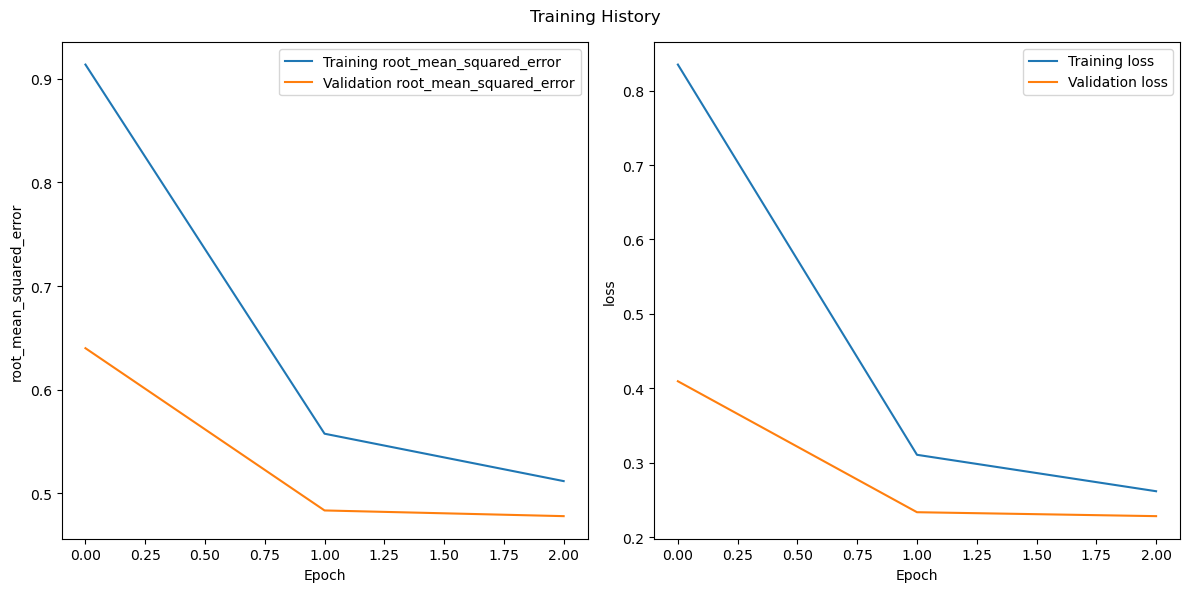

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# plot training history
reporting.plot_training_history(axes[0], history, "root_mean_squared_error")
reporting.plot_training_history(axes[1], history, "loss")

fig.suptitle("Training History")
fig.tight_layout()
plt.show()


In [18]:
index_slider = widgets.IntSlider(min=0, max=OUTPUT_STEPS-2 , step=1, value=0, description='Fortnight:', layout=widgets.Layout(width='60%', margin='0px 0px 0px 0px'))

def update_plot(index):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 8))
    fig.suptitle('Model Resuts')
    plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)
    reporting.plot_result_in_fixed_position(axes[0,0],ppna_df_feature_cross['longitude'][400000], ppna_df_feature_cross['latitude'][400000],index, model, test_df_feature_cross,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    reporting.plot_result_in_fixed_position(axes[0,1],ppna_df_feature_cross['longitude'][0], ppna_df_feature_cross['latitude'][0],index,  model, test_df_feature_cross,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    reporting.plot_result_in_fixed_position(axes[1,0],ppna_df_feature_cross['longitude'][10000], ppna_df_feature_cross['latitude'][10000],index,  model, test_df_feature_cross,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)
    reporting.plot_result_in_fixed_position(axes[1,1],ppna_df_feature_cross['longitude'][30000], ppna_df_feature_cross['latitude'][30000],index,   model, test_df_feature_cross,INPUT_STEPS,OUTPUT_STEPS, test_mean, test_std)    


widgets.interactive(update_plot, index=index_slider)

interactive(children=(IntSlider(value=0, description='Fortnight:', layout=Layout(margin='0px 0px 0px 0px', wid…